# Lab 3 - Exploring and manipulating data. 
Here is what we will do:
1. Prepare the data
2. Train 3 models
 - Decision Tree
 - SVM using rgb
 - Neural Net
3. Get model performance on train and test sets
4. Create appropriate graphs

### 1. Prepare the data

#### Read the data

In [134]:
import pandas as pd
# Load the CSV file
file_name = 'Howell.csv'
howell_full_df = pd.read_csv(file_name, sep=";")


#### Plot the data

Text(0, 0.5, 'weight (kg)')

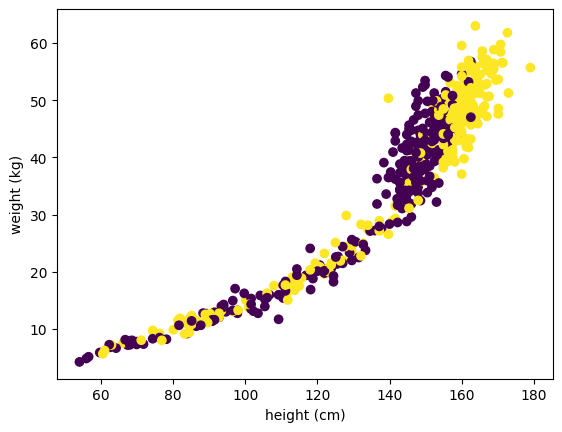

In [135]:
import matplotlib.pyplot as plt
height = howell_full_df['height']
weight = howell_full_df['weight']
gender = howell_full_df['male']
plt.scatter(height, weight, c=gender)
plt.xlabel('height (cm)')
plt.ylabel('weight (kg)')

#### Adding a new feature

In [136]:
# Compute bmi based on height and weight metric units
def bmi(height, weight):
    return 10000*weight/(height**2)
#print(bmi(150, 40))
new_feature = bmi(howell_full_df['height'], howell_full_df['weight'])
#print(new_feature)
howell_full_df['bmi'] = new_feature
howell_full_df.head(n=10)

,height,weight,age,male,bmi
0,151.765,47.825606,63.0,1,20.764297
1,139.700,36.485807,63.0,0,18.695244
2,136.525,31.864838,65.0,0,17.095718
3,156.845,53.041914,41.0,1,21.561444
4,145.415,41.276872,51.0,0,19.520384
5,163.830,62.992589,35.0,1,23.469433
6,149.225,38.243476,32.0,0,17.174108
7,168.910,55.479971,27.0,1,19.445786
8,147.955,34.869885,19.0,0,15.929099
9,165.100,54.487739,54.0,1,19.989625


#### Add a categorical feature

In [137]:
import numpy as np
def bmi_category(bmi):
    # bmi can only be a single value
    if bmi < 18.5: return 'Underweight'
    if bmi < 25.0: return 'Normal'
    if bmi < 30.0: return 'Overweight'
    return 'Obese'

vector_bmi_category = np.vectorize(bmi_category)
howell_full_df['bmi class'] = vector_bmi_category(howell_full_df['bmi'])
#print(howell_full_df.head(n=10))
howell_full_df['bmi class'].value_counts()

bmi class
Underweight    341
Normal         202
Overweight       1
Name: count, dtype: int64

#### Splitting the data by age

In [138]:
over18 = howell_full_df["age"] > 18
print(over18)
# Only keep the true instances
howell_adults = howell_full_df[over18]
howell_children = howell_full_df[~over18] # ~ is not in numpy
#print("There are ", len(howell_adults), " adult instances")
#print(howell_adults)
#print("There are ", len(howell_children), " child instances")
#print(howell_children)

0       True
1       True
2       True
3       True
4       True
       ...  
539    False
540     True
541     True
542    False
543     True
Name: age, Length: 544, dtype: bool


#### Plot with masking 

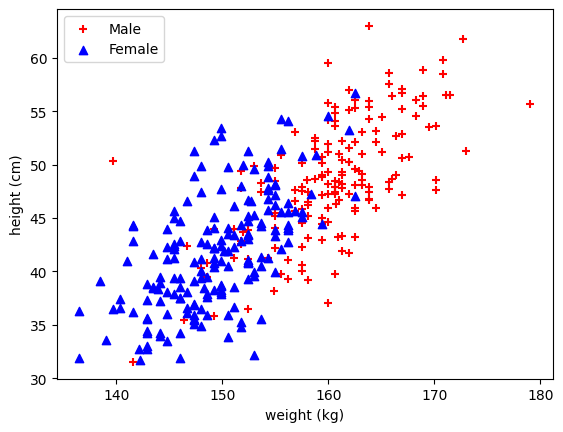

In [139]:
male_height = np.ma.masked_where(howell_adults['male']==0,
 howell_adults['height'])
female_height = np.ma.masked_where(howell_adults['male']==1,
 howell_adults['height'])
weight = howell_adults['weight']
plt.scatter(male_height, weight, c='red', marker='+')
plt.scatter(female_height, weight, c='blue', marker='^')
plt.xlabel('weight (kg)')
plt.ylabel('height (cm)')
plt.legend(['Male', 'Female'])
plt.show()

#### Stratified Train/Test Data Split

In [140]:
from sklearn.model_selection import StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2,
 random_state=123)
for train_indices, test_indices in splitter.split(howell_adults,
howell_adults['male']):
 train_set = howell_adults.iloc[train_indices]
 test_set = howell_adults.iloc[test_indices]

print('Train size: ', len(train_set), 'Test size: ', len(test_set))
#print('Adult counts', howell_adults['male'].value_counts())
#print('Train counts', train_set['male'].value_counts())
#print('Test counts', test_set['male'].value_counts())


Train size:  276 Test size:  70


### 2. Train and evaluate Models

In [141]:
import matplotlib.pyplot as plt
import numpy as np

def plot2FeatureBinaryConfusion(data_set, feature1Label, feature2Label, targetLabel, predicted, positive=1, negative=0):
## assumes that the target is 0/1

    
    target = data_set[targetLabel]
    
    # Filter with feature 1
    feature1_positives = np.ma.masked_where(target==negative, 
                     data_set[feature1Label])
    true_positive = np.ma.masked_where(predicted!=target, feature1_positives)
    false_negative = np.ma.masked_where(predicted==target, feature1_positives)
    feature1_negatives = np.ma.masked_where(target==positive, 
                     data_set[feature1Label])
    true_negative = np.ma.masked_where(predicted!=target, feature1_negatives)
    false_positive = np.ma.masked_where(predicted==target,feature1_negatives)

   
    feature2 = data_set[feature2Label]
    plt.scatter(true_positive, feature2, c='green', marker='o')
    plt.scatter(false_positive, feature2, c='red', marker='^')
    plt.scatter(true_negative, feature2, c='blue', marker='o')
    plt.scatter(false_negative, feature2, c='orange', marker='^')



    plt.xlabel(feature1Label)
    plt.ylabel(feature2Label)
    plt.legend(['True Positive', 'False Positive', 'True Negative', 'False Negative'])
    plt.show()

#### A.1: Decision Tree for the input feature height and output feature male

In [142]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
X = train_set[['height']]
y = train_set['male']
X_test = test_set[['height']]
y_test = test_set['male']
tree_model = DecisionTreeClassifier()
tree_model.fit(X,y)

DecisionTreeClassifier()

##### Result for training set

In [143]:
y_pred = tree_model.predict(X)
print('Results for decision tree on training data')
print(' Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred))
print('Recall is ', recall_score(y,y_pred))
print('F1 is ', f1_score(y, y_pred))

Results for decision tree on training data
 Default settings
Confusion Matrix
[[139   6]
 [ 22 109]]
Accuracy is  0.8985507246376812
Precision is  0.9478260869565217
Recall is  0.8320610687022901
F1 is  0.8861788617886179


##### Result for testing set

In [144]:
y_test_pred = tree_model.predict(X_test)
print('Results for decision tree on test data')
print(' Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred))
print('Recall is ', recall_score(y_test,y_test_pred))
print('F1 is ', f1_score(y_test, y_test_pred))

Results for decision tree on test data
 Default settings
Confusion Matrix
[[33  4]
 [ 9 24]]
Accuracy is  0.8142857142857143
Precision is  0.8571428571428571
Recall is  0.7272727272727273
F1 is  0.7868852459016393


##### Results
Basic results for our classification model to predict gender
on the Howell data.
| Model | Training Features | Set | Accuracy | F1 |
|:---|:---|:---|:---|:---|
|Decision Tree|Height|Training|89.85|88.62|
|Decision Tree|Height|Test|81.43|78.69|

#### A.2: Decision Tree for the input feature weight and output feature male

In [145]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
X = train_set[['weight']]
y = train_set['male']
X_test = test_set[['weight']]
y_test = test_set['male']
tree_model = DecisionTreeClassifier()
tree_model.fit(X,y)

DecisionTreeClassifier()

##### Result for training set

In [146]:
y_pred = tree_model.predict(X)
print('Results for decision tree on training data')
print(' Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred))
print('Recall is ', recall_score(y,y_pred))
print('F1 is ', f1_score(y, y_pred))

Results for decision tree on training data
 Default settings
Confusion Matrix
[[145   0]
 [ 11 120]]
Accuracy is  0.9601449275362319
Precision is  1.0
Recall is  0.916030534351145
F1 is  0.9561752988047809


##### Result for testing set

In [147]:
y_test_pred = tree_model.predict(X_test)
print('Results for decision tree on test data')
print(' Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred))
print('Recall is ', recall_score(y_test,y_test_pred))
print('F1 is ', f1_score(y_test, y_test_pred))

Results for decision tree on test data
 Default settings
Confusion Matrix
[[25 12]
 [14 19]]
Accuracy is  0.6285714285714286
Precision is  0.6129032258064516
Recall is  0.5757575757575758
F1 is  0.59375


##### Results
Basic results for our classification model to predict gender
on the Howell data.
| Model | Training Features | Set | Accuracy | F1 |
|:---|:---|:---|:---|:---|
|Decision Tree|weight|Training|96.01|95.62|
|Decision Tree|weight|Test|62.86|59.38|

#### A.3: Decision Tree for the input feature height and weight and output feature male

In [148]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
X = train_set[['height','weight']]
y = train_set['male']
X_test = test_set[['height','weight']]
y_test = test_set['male']
tree_model = DecisionTreeClassifier()
tree_model.fit(X,y)

DecisionTreeClassifier()

##### Result for training set

In [149]:
y_pred = tree_model.predict(X)
print('Results for decision tree on training data')
print(' Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred))
print('Recall is ', recall_score(y,y_pred))
print('F1 is ', f1_score(y, y_pred))

Results for decision tree on training data
 Default settings
Confusion Matrix
[[145   0]
 [  0 131]]
Accuracy is  1.0
Precision is  1.0
Recall is  1.0
F1 is  1.0


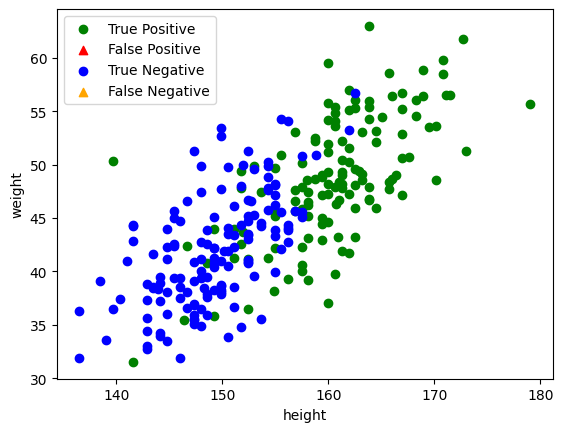

In [150]:
plot2FeatureBinaryConfusion(train_set, 'height', 'weight', 'male', y_pred)

##### Result for testing set

In [151]:
y_test_pred = tree_model.predict(X_test)
print('Results for decision tree on test data')
print(' Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred))
print('Recall is ', recall_score(y_test,y_test_pred))
print('F1 is ', f1_score(y_test, y_test_pred))

Results for decision tree on test data
 Default settings
Confusion Matrix
[[28  9]
 [11 22]]
Accuracy is  0.7142857142857143
Precision is  0.7096774193548387
Recall is  0.6666666666666666
F1 is  0.6875


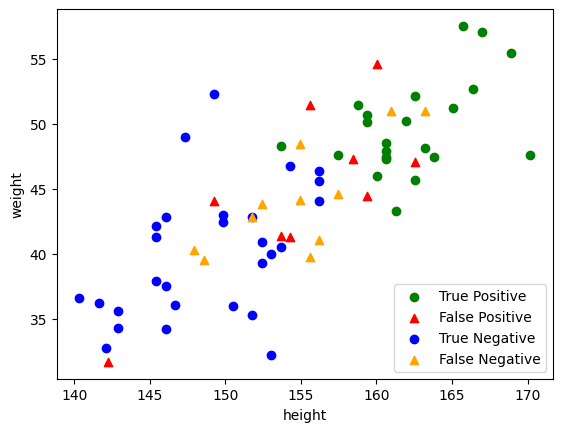

In [152]:
plot2FeatureBinaryConfusion(test_set, 'height', 'weight', 'male', y_test_pred)

##### Results
Basic results for our classification model to predict gender
on the Howell data.
| Model | Training Features | Set | Accuracy | F1 |
|:---|:---|:---|:---|:---|
|Decision Tree|Height, weight|Training|1.0|1.0|
|Decision Tree|Height, weight|Test|71.43|68.75|

##### Decision Tree Specific Visualization 

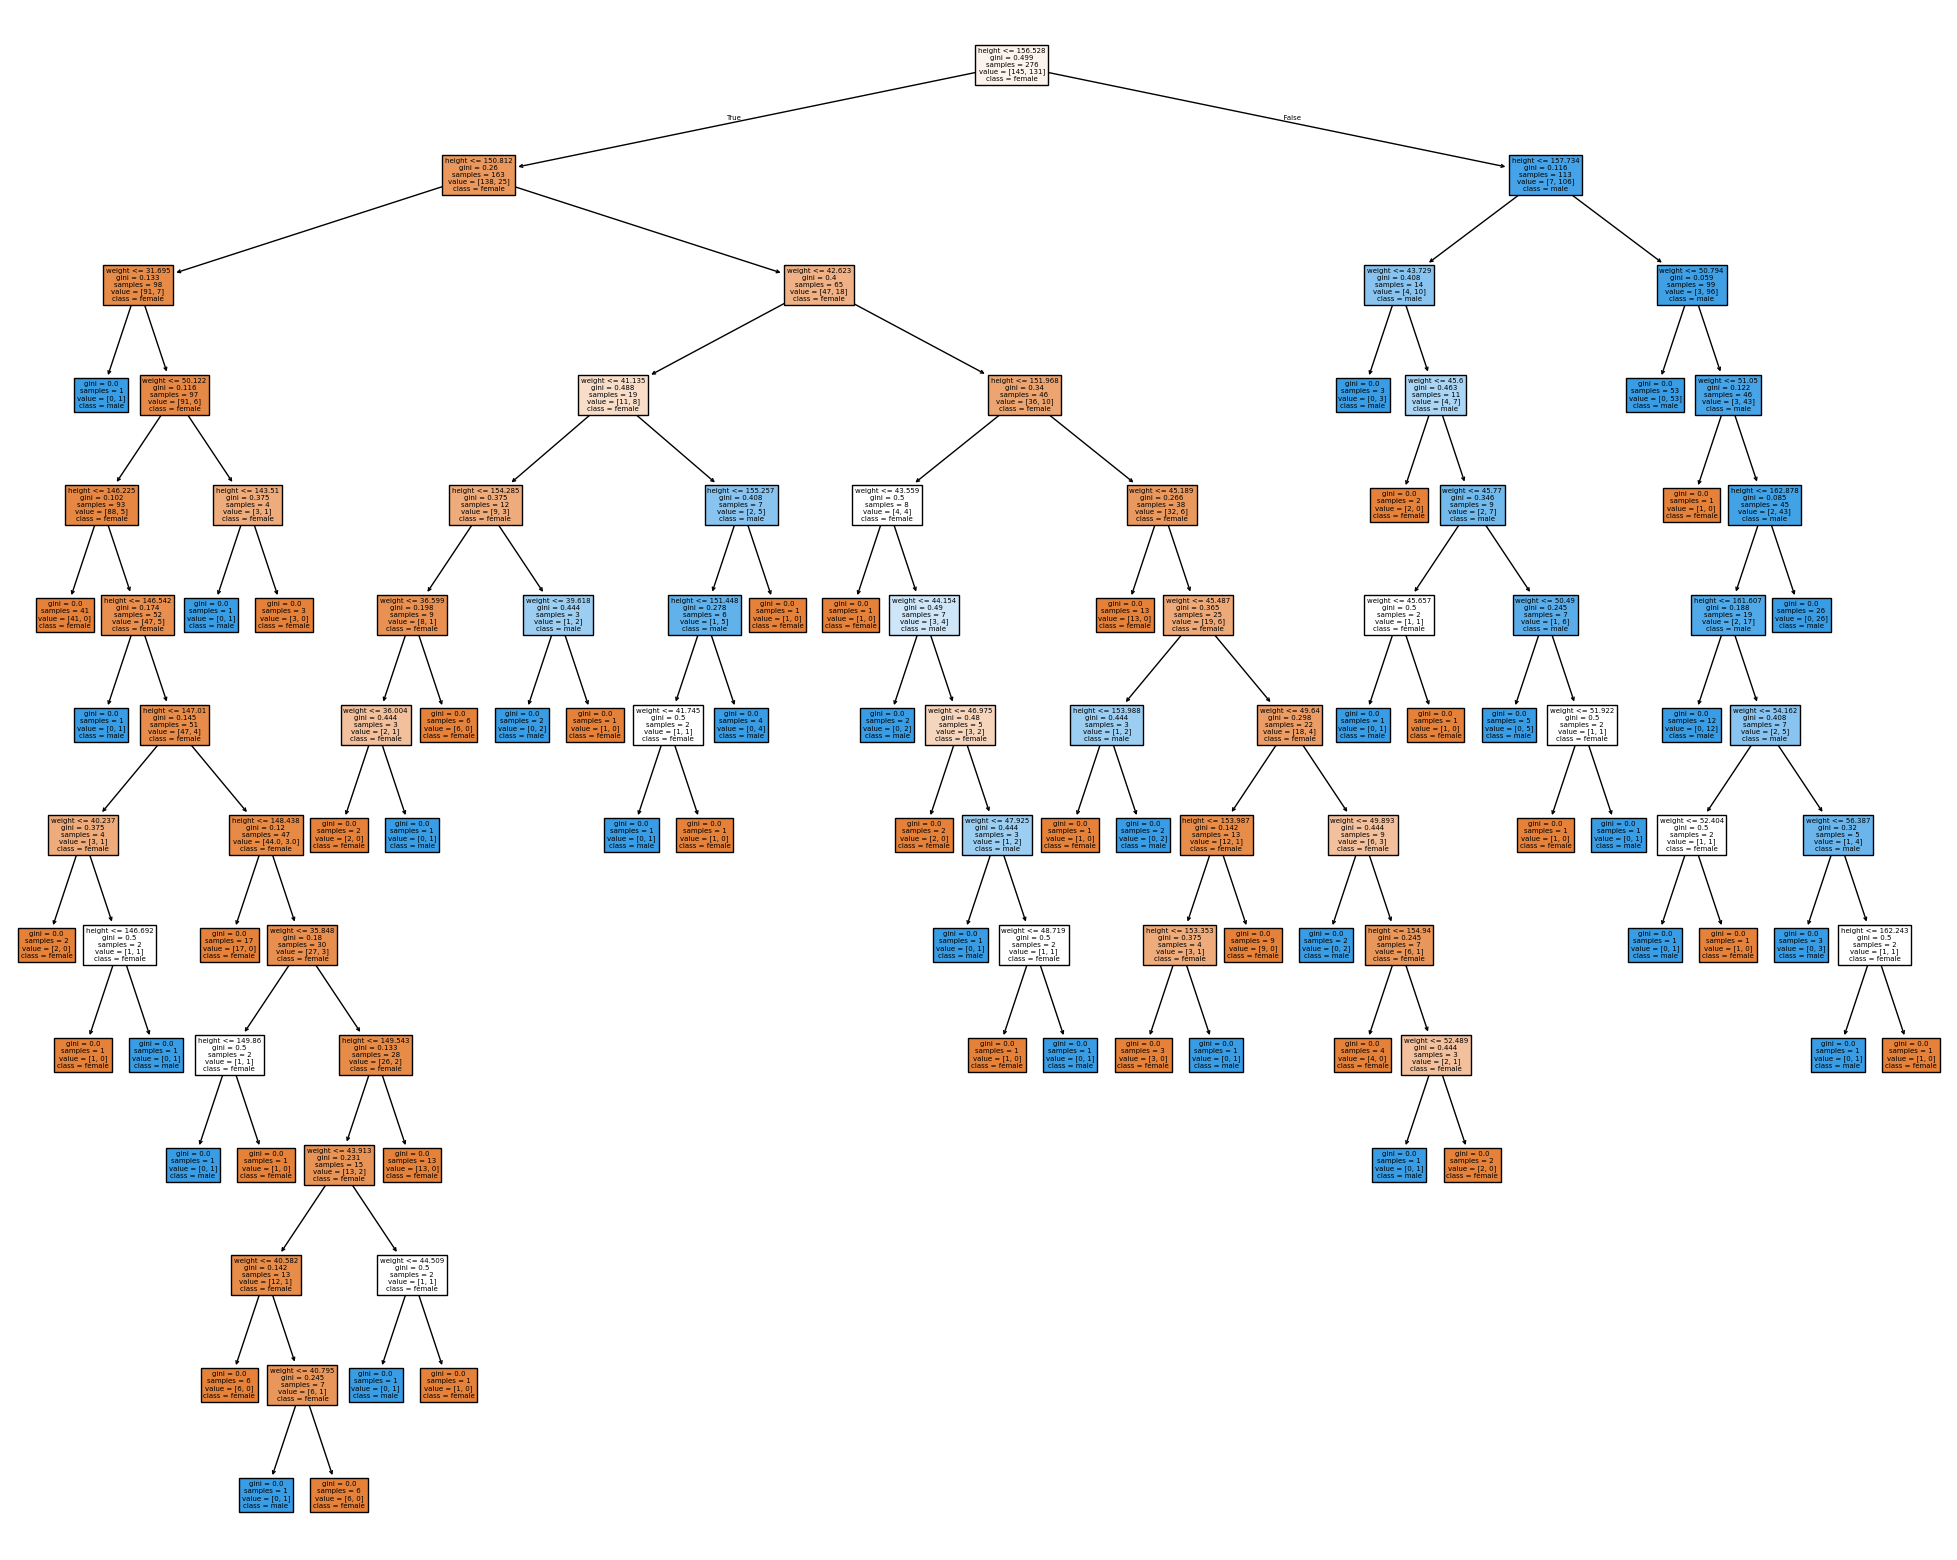

In [153]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(25,20))
plot_tree(tree_model,
 feature_names=['height', 'weight'],
class_names=['female', 'male'],
filled=True)
fig.savefig("decision_tree_howell.png")


#### B.1: Support Vector Machine for input feature height and output feature male

In [154]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
X = train_set[['height']]
y = train_set['male']
X_test = test_set[['height']]
y_test = test_set['male']
svc_model = SVC()
svc_model.fit(X,y)

SVC()

##### Result for training data

In [155]:
y_pred = svc_model.predict(X)
print('Results for decision tree on training data')
print(' Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred))
print('Recall is ', recall_score(y,y_pred))
print('F1 is ', f1_score(y, y_pred))

Results for decision tree on training data
 Default settings
Confusion Matrix
[[133  12]
 [ 24 107]]
Accuracy is  0.8695652173913043
Precision is  0.8991596638655462
Recall is  0.816793893129771
F1 is  0.856


##### Result for testing data

In [156]:
y_test_pred = svc_model.predict(X_test)
print('Results for decision tree on test data')
print(' Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred))
print('Recall is ', recall_score(y_test,y_test_pred))
print('F1 is ', f1_score(y_test, y_test_pred))

Results for decision tree on test data
 Default settings
Confusion Matrix
[[30  7]
 [ 8 25]]
Accuracy is  0.7857142857142857
Precision is  0.78125
Recall is  0.7575757575757576
F1 is  0.7692307692307693


##### Results
Basic results for our classification model to predict gender
on the Howell data.
| Model | Training Features | Set | Accuracy | F1 |
|:---|:---|:---|:---|:---|
|SVC|Height|Training|86.96|85.60|
|SVC|Height|Test|78.57|76.92|

#### B.2: Support Vector Machine for input feature weight and output feature male

In [157]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
X = train_set[['weight']]
y = train_set['male']
X_test = test_set[['weight']]
y_test = test_set['male']
svc_model = SVC()
svc_model.fit(X,y)

SVC()

##### Result for training data

In [158]:
y_pred = svc_model.predict(X)
print('Results for decision tree on training data')
print(' Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred))
print('Recall is ', recall_score(y,y_pred))
print('F1 is ', f1_score(y, y_pred))

Results for decision tree on training data
 Default settings
Confusion Matrix
[[115  30]
 [ 35  96]]
Accuracy is  0.7644927536231884
Precision is  0.7619047619047619
Recall is  0.732824427480916
F1 is  0.7470817120622568


##### Result for testing data

In [159]:
y_test_pred = svc_model.predict(X_test)
print('Results for decision tree on test data')
print(' Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred))
print('Recall is ', recall_score(y_test,y_test_pred))
print('F1 is ', f1_score(y_test, y_test_pred))

Results for decision tree on test data
 Default settings
Confusion Matrix
[[29  8]
 [10 23]]
Accuracy is  0.7428571428571429
Precision is  0.7419354838709677
Recall is  0.696969696969697
F1 is  0.71875


##### Results
Basic results for our classification model to predict gender
on the Howell data.
| Model | Training Features | Set | Accuracy | F1 |
|:---|:---|:---|:---|:---|
|SVC|weight|Training|76.45|74.71|
|SVC|weight|Test|74.23|71.88|

#### B.3: Support Vector Machine for input feature height and weight and output feature male

In [160]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
X = train_set[['height','weight']]
y = train_set['male']
X_test = test_set[['height','weight']]
y_test = test_set['male']
svc_model = SVC()
svc_model.fit(X,y)

SVC()

##### Result for training data

In [161]:
y_pred = svc_model.predict(X)
print('Results for decision tree on training data')
print(' Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred))
print('Recall is ', recall_score(y,y_pred))
print('F1 is ', f1_score(y, y_pred))

Results for decision tree on training data
 Default settings
Confusion Matrix
[[126  19]
 [ 23 108]]
Accuracy is  0.8478260869565217
Precision is  0.8503937007874016
Recall is  0.8244274809160306
F1 is  0.8372093023255814


##### Result for testing data

In [162]:
y_test_pred = svc_model.predict(X_test)
print('Results for decision tree on test data')
print(' Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred))
print('Recall is ', recall_score(y_test,y_test_pred))
print('F1 is ', f1_score(y_test, y_test_pred))

Results for decision tree on test data
 Default settings
Confusion Matrix
[[29  8]
 [ 8 25]]
Accuracy is  0.7714285714285715
Precision is  0.7575757575757576
Recall is  0.7575757575757576
F1 is  0.7575757575757576


##### Results
Basic results for our classification model to predict gender
on the Howell data.
| Model | Training Features | Set | Accuracy | F1 |
|:---|:---|:---|:---|:---|
|SVC|Height, weight|Training|84.78|83.72|
|SVC|Height, weight|Test|77.14|75.76|

#### SVC Specific Visualization

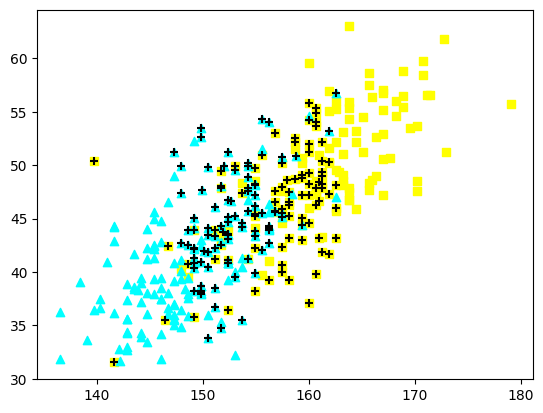

In [163]:
# get the values for the support vectors (the special instances)
support_x = [x for (x,y) in svc_model.support_vectors_]
support_y = [y for (x,y) in svc_model.support_vectors_]
plt.scatter(male_height, weight, c='yellow', marker='s')
plt.scatter(female_height, weight, c='cyan', marker='^')
plt.scatter(support_x, support_y, c='black', marker='+')

#### C.1: Neural Network for input feature height and output feature male

In [164]:
### Train and evaluate Neural Net model
from sklearn.neural_network import MLPClassifier
nn_model = MLPClassifier(hidden_layer_sizes=(50, 25, 10), solver='lbfgs')
X = train_set[['height']]
y = train_set['male']
X_test = test_set[['height']]
y_test = test_set['male']
nn_model.fit(X,y)

MLPClassifier(hidden_layer_sizes=(50, 25, 10), solver='lbfgs')

##### Result for training data

In [165]:
y_pred = nn_model.predict(X)
print('Results for decision tree on training data')
print(' Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred))
print('Recall is ', recall_score(y,y_pred))
print('F1 is ', f1_score(y, y_pred))

Results for decision tree on training data
 Default settings
Confusion Matrix
[[130  15]
 [ 23 108]]
Accuracy is  0.8623188405797102
Precision is  0.8780487804878049
Recall is  0.8244274809160306
F1 is  0.8503937007874016


##### Result for testing data

In [166]:
y_test_pred = nn_model.predict(X_test)
print('Results for decision tree on test data')
print(' Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred))
print('Recall is ', recall_score(y_test,y_test_pred))
print('F1 is ', f1_score(y_test, y_test_pred))

Results for decision tree on test data
 Default settings
Confusion Matrix
[[29  8]
 [ 7 26]]
Accuracy is  0.7857142857142857
Precision is  0.7647058823529411
Recall is  0.7878787878787878
F1 is  0.7761194029850746


##### Results
Basic results for our classification model to predict gender
on the Howell data.
| Model | Training Features | Parameters |Set | Accuracy | F1 |
|:---|:---|:---|:---|:---|:---|
|Neural Network|Height|(50,25,10), lbfgs|Training|86.23|85.04|
|Neural Network|Height|(50,25,10), lbfgs|Test|78.57|77.61|

#### C.2: Neural Network for input feature weight and output feature male

In [167]:
### Train and evaluate Neural Net model
from sklearn.neural_network import MLPClassifier
nn_model = MLPClassifier(hidden_layer_sizes=(50, 25, 10), solver='lbfgs')
X = train_set[['weight']]
y = train_set['male']
X_test = test_set[['weight']]
y_test = test_set['male']
nn_model.fit(X,y)

MLPClassifier(hidden_layer_sizes=(50, 25, 10), solver='lbfgs')

##### Result for training data

In [168]:
y_pred = nn_model.predict(X)
print('Results for decision tree on training data')
print(' Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred))
print('Recall is ', recall_score(y,y_pred))
print('F1 is ', f1_score(y, y_pred))

Results for decision tree on training data
 Default settings
Confusion Matrix
[[115  30]
 [ 35  96]]
Accuracy is  0.7644927536231884
Precision is  0.7619047619047619
Recall is  0.732824427480916
F1 is  0.7470817120622568


##### Result for testing data

In [169]:
y_test_pred = nn_model.predict(X_test)
print('Results for decision tree on test data')
print(' Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred))
print('Recall is ', recall_score(y_test,y_test_pred))
print('F1 is ', f1_score(y_test, y_test_pred))

Results for decision tree on test data
 Default settings
Confusion Matrix
[[29  8]
 [10 23]]
Accuracy is  0.7428571428571429
Precision is  0.7419354838709677
Recall is  0.696969696969697
F1 is  0.71875


##### Results
Basic results for our classification model to predict gender
on the Howell data.
| Model | Training Features |Parameters | Set | Accuracy | F1 |
|:---|:---|:---|:---|:---|:---|
|Neural Network|Weight|(50,25,10), lbfgs |Training|76.45|74.71|
|Neural Network|Weight|(50,25,10), lbfgs |Test|74.29|69.70|

#### C.3: Neural Network for input feature height and weight and output feature male

In [170]:
### Train and evaluate Neural Net model
from sklearn.neural_network import MLPClassifier
nn_model = MLPClassifier(hidden_layer_sizes=(50, 25, 10), solver='lbfgs')
X = train_set[['height','weight']]
y = train_set['male']
X_test = test_set[['height','weight']]
y_test = test_set['male']
nn_model.fit(X,y)

c:\MS\data_analytics\github\44670_MachineLearning\AMLLab3\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(hidden_layer_sizes=(50, 25, 10), solver='lbfgs')

##### Result for training data

In [171]:
y_pred = nn_model.predict(X)
print('Results for decision tree on training data')
print(' Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred))
print('Recall is ', recall_score(y,y_pred))
print('F1 is ', f1_score(y, y_pred))

Results for decision tree on training data
 Default settings
Confusion Matrix
[[128  17]
 [ 22 109]]
Accuracy is  0.8586956521739131
Precision is  0.8650793650793651
Recall is  0.8320610687022901
F1 is  0.8482490272373541


##### Result for testing data

In [172]:
y_test_pred = nn_model.predict(X_test)
print('Results for decision tree on test data')
print(' Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred))
print('Recall is ', recall_score(y_test,y_test_pred))
print('F1 is ', f1_score(y_test, y_test_pred))

Results for decision tree on test data
 Default settings
Confusion Matrix
[[29  8]
 [ 7 26]]
Accuracy is  0.7857142857142857
Precision is  0.7647058823529411
Recall is  0.7878787878787878
F1 is  0.7761194029850746


##### Results
Basic results for our classification model to predict gender
on the Howell data.
| Model | Training Features | Parameters | Set | Accuracy | F1 |
|:---|:---|:---|:---|:---|:---|
|Neural Network|Height, weight|(50,25,10), lbfgs |Training|86.59|85.60|
|Neural Network|Height, weight|(50,25,10), lbfgs| Test|77.14|76.47|